### <span style="color:rgb(234,81,96)">Optimization for Machine Learning</span>

### <span style="color:rgb(234,81,96)">Master 2 IASD Apprentissage 2023-2024</span>


# <span style="color:rgb(234,81,96)">Lab 02 - Around gradient descent</span>


<!--
Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OML/PolyOML.pdf).
-->

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/OAA/SourcesLabOAA02.zip).

The NumPy library is used in this lab. A quick tutorial for NumPy is available 
[here](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@lamsade.dauphine.fr**.

# <span style="color:rgb(234,81,96)">Introduction</span>

This lab session aims at illustrating the use of gradient descent techniques on classical nonlinear optimization problems.


*Note: All blocks of this notebook are built to be run sequentially. In particular, the block below should be executed before going any further.*

In [1]:
# Preamble: useful toolboxes, librairies, functions, etc.

# Display
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform, choice # Probability distributions

# SciPy - Efficient mathematical calculation
from scipy.linalg import norm # Euclidean norm
from scipy.linalg.special_matrices import toeplitz # Toeplitz matrices
from scipy.linalg import svdvals # Singular value decomposition
from scipy.optimize import check_grad # Check derivatives
from scipy.optimize import fmin_l_bfgs_b # Efficient method for minimization

# <span style="color:rgb(234,81,96)">Part 1 - Least squares</span>

## <span style="color:rgb(234,81,96)">1.1 Data generation</span>

We consider a dataset $\{(\mathbf{x}_i,y_i)\}_{i=1,\dots,n}$, where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$, available in the form of:

- a feature matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$;
- and a vector of labels $\mathbf{y} \in \mathbb{R}^n$. 

The dataset will be produced according to the procedure below, that aims at generating 
data by controlling the noise and correlation levels.

*NB: Students are not expected to know this procedure.*

In [2]:
# Data generation.
# This code is inspired by a generator proposed by A. Gramfort.
    
def simu_linreg(w, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    w : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

As a result, the data will be generated from an underlying linear trend corrupted with Gaussian noise.

## <span style="color:rgb(234,81,96)">1.2 Linear model and least-squares regression</span>

Our objective is to build a linear model that best fits our data. That is, given $(\mathbf{X},\mathbf{y})$, we seek 
a vector $\mathbf{w}$ such that $\mathbf{X} \mathbf{w} -\mathbf{y} \approx 0$.

Without any knowledge of the error behavior (or assuming these errors are Gaussian), one can formulate the task 
above as a linear least-squares problem:
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d} 
    f(\mathbf{w}) := \frac{1}{2 n} \|\mathbf{X} \mathbf{w} - \mathbf{y}\|^2 
    = \frac{1}{2n} \sum_{i=1}^n (\mathbf{x}_i^T \mathbf{w} - y_i)^2.
$$ 

Any value less than or equal to $0$ is a *lower bound* on the function $f$ because $f$ is nonnegative. The value $0$ *may be* the optimal value, but not necessarily. It depends on whether there exists $\mathbf{w}^*$ such that $\mathbf{X} \mathbf{w}^* = \mathbf{y}$.

The above problem can be reformulated as a *quadratic optimization problem* of the form
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d} \frac{1}{2}\mathbf{w}^T \mathbf{A} \mathbf{w} - \mathbf{b}^T \mathbf{w} + c.
$$

The gradient of this quadratic objective function above is given by:
$$
    \nabla f(\mathbf{w}) 
    = \mathbf{A} \mathbf{w} - \mathbf{b} 
    = \frac{1}{n}\left( \mathbf{X}^T \mathbf{X} \mathbf{w} - \mathbf{X}^T \mathbf{y}\right).
$$
For any $(\mathbf{v},\mathbf{w})$, we thus have
$$
    \| \nabla f(\mathbf{v}) - \nabla f(\mathbf{w}) \| 
    \le \| \mathbf{A} (\mathbf{v}-\mathbf{w}) \| 
    \le \|\mathbf{A} \| \|\mathbf{v} -\mathbf{w}\|,
$$
where the last line comes from the Cauchy-Schwarz inequality.

As a result, a Lipschitz constant for $\nabla f$ is $\|\mathbf{A}\| = \tfrac{1}{n}\|\mathbf{X}^T \mathbf{X}\|$.

### <span style="color:rgb(234,81,96)">Python class for the linear regression problem</span>

*The code below defines a Python class for linear regression problems. Using the above formulae, we compute $f(\mathbf{w})$ and $\nabla f(\mathbf{w})$ within the Python class encoding the linear regression problem.*  

*Useful functions:* For any NumPy array X, X.dot(v) is the matrix-vector product $X v$ if X is a matrix, or the scalar product $x^T v$ if it is a vector, and X.T denotes the transpose matrix $X^T$.

In [3]:
# Python class for linear regression problems
class LinReg(object):
    '''
        Linear regression problems (least-squares formulation).
        
        Attributes:
            X: Two-way array representing a data matrix (feature vectors/individuals/...) 
            y: One-way array representing a data vector (labels/measurements/...)
            n,d: Dimensions of the problem (X is n-by-d, y is n-dimensional)
            
        Methods:
            fun: Computes the objective value for the least-squares regression problem.
            grad: Computes the gradient vector for the least-squares regression problem.
            lipgrad: Lipschitz constant for the gradient.
    '''   

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
    
    # Objective value
    def fun(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) 
    
    # Full gradient computation
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n 

    # Lipschitz constant for the gradient
    def lipgrad(self):
        L = norm(self.X, ord=2) ** 2 / self.n 
        return L 

### <span style="color:rgb(234,81,96)">Generating the problem instance</span>

In [4]:
# Dimensions for the instance
d = 50
n = 1000
idx = np.arange(d)

# Fix random seed for reproducibility
np.random.seed(1)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

# Computing the feature matrix and label vector
X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)

# Generating the corresponding linear regression instance
pblinreg = LinReg(X, y)

# Check correctness of the gradient function (using a finite-difference estimate)
# This value should be around 10^(-6) in magnitude
# (More later on the interest of estimating derivatives)
check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d))

1.9057353729057355e-06

In this lab session, we work with a relatively simple problem of moderate dimensions. This will allow us to employ a second-order method (in our case, L-BFGS) to find an accurate solution. This will provide us with both an approximate minimizer and a target objective value.

In [5]:
# Use L-BFGS-B to find an accurate solution for the linear regression problem

w_init = np.zeros(d)

# Compute the optimal solution for linear regression
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, w_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(w_min_lin)))

0.4737086058623297
4.81489075811467e-10


## <span style="color:rgb(234,81,96)">2.3 Gradient Descent</span>


The gradient descent algorithm applied to a function $f$ is defined by an initial point $w_0$ together with the iteration:

$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla f(\mathbf{w}_k),
$$

The code below implements gradient descent with three possible choices for the stepsize sequence $\{\alpha_k\}_k$:*

a) $\alpha_k = \frac{1}{L}$, where $L=\frac{\|\mathbf{X}^T \mathbf{X}\|}{n}$ is the Lipschitz constant for $\nabla f$;*

b) $\alpha_k = \frac{\alpha_0}{k+1}$;

c) $\alpha_k = \frac{\alpha_0}{\sqrt{k+1}}$.


In [6]:
# Implementation of gradient descent
def grad_desc(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000, verbose=True): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun(w) evaluates the objective function at a given vector w
                problem.d returns the expected length of the input
                problem.grad(w) evaluates the gradient of the objective function at a vector w
                problem.lipgrad() returns the Lipschitz constant for the gradient
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize (see above)
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/(k+1)
                2: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            w_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length at most n_iter)
            normits: History of distances between iterates and optimum (Numpy array of length at most n_iter)
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of current iterate   
    w = w0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):
        
        # Compute the gradient
        g = problem.grad(w)
        
        # Select the stepsize and perform the update
        if stepchoice==0:
            w[:] = w - (1/L) * g
        elif stepchoice==1:
            w[:] = w - (step0/(k+1))*g
        else:
            w[:] = w - (step0/(sqrt(k+1)))*g
        
        # Compute and plot the new objective value and distance to the minimum
        obj = problem.fun(w)
        objvals.append(obj)
        nmin = norm(w-wtarget)
        normits.append(nmin)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(normits)

In [7]:
# Validate your implementation here by running this short script.
w0 = np.zeros(d)
w_a, obj_a, nits_a = grad_desc(w0,pblinreg,w_min_lin,stepchoice=0,step0=1, n_iter=100)
w_b, obj_b, nits_b = grad_desc(w0,pblinreg,w_min_lin,stepchoice=1,step0=1, n_iter=100)
w_c, obj_c, nits_c = grad_desc(w0,pblinreg,w_min_lin,stepchoice=2,step0=1, n_iter=100)

Gradient Descent:
  iter   |   fval   |   dist  
       0 | 2.58e+00 | 2.33e+00
       0 | 9.81e-01 | 1.20e+00
       1 | 6.23e-01 | 6.64e-01
       2 | 5.20e-01 | 3.76e-01
       3 | 4.89e-01 | 2.16e-01
       4 | 4.79e-01 | 1.25e-01
       5 | 4.75e-01 | 7.36e-02
       6 | 4.74e-01 | 4.35e-02
       7 | 4.74e-01 | 2.58e-02
       8 | 4.74e-01 | 1.54e-02
       9 | 4.74e-01 | 9.24e-03
      10 | 4.74e-01 | 5.55e-03
      11 | 4.74e-01 | 3.35e-03
      12 | 4.74e-01 | 2.03e-03
      13 | 4.74e-01 | 1.23e-03
      14 | 4.74e-01 | 7.46e-04
      15 | 4.74e-01 | 4.54e-04
      16 | 4.74e-01 | 2.77e-04
      17 | 4.74e-01 | 1.69e-04
      18 | 4.74e-01 | 1.03e-04
      19 | 4.74e-01 | 6.32e-05
      20 | 4.74e-01 | 3.87e-05
      21 | 4.74e-01 | 2.38e-05
      22 | 4.74e-01 | 1.46e-05
      23 | 4.74e-01 | 8.98e-06
      24 | 4.74e-01 | 5.53e-06
      25 | 4.74e-01 | 3.41e-06
      26 | 4.74e-01 | 2.10e-06
      27 | 4.74e-01 | 1.30e-06
      28 | 4.74e-01 | 8.00e-07
      29 | 4.74e-01 |

Use the script below to compare the three variants of gradient descent.

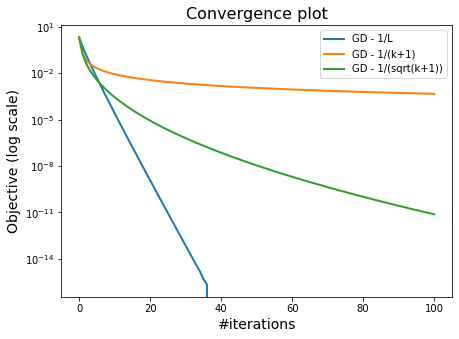

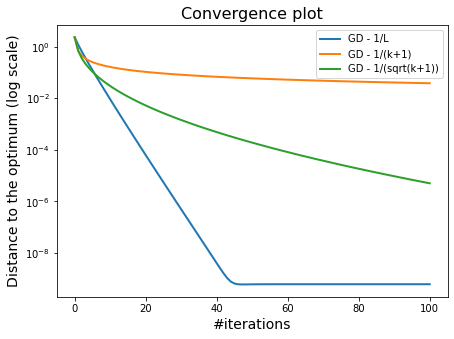

In [8]:
# Comparison of three variants of gradient descent

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_lin, label="GD - 1/(k+1)", lw=2)
plt.semilogy(obj_c-f_min_lin, label="GD - 1/(sqrt(k+1))", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

# In terms of distance to the optimum (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="GD - 1/L", lw=2)
plt.semilogy(nits_b , label="GD - 1/(k+1)", lw=2)
plt.semilogy(nits_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the optimum (log scale)", fontsize=14)
plt.legend()

### <span style="color:rgb(234,81,96)">Additional remarks</span>

We have compared our algorithms using the distance to an (approximate) solution, and the distance to the optimal value. Under the appropriate assumptions, it is possible to derive convergence rates/complexity bounds for such a distance. In practice, we do not know the optimal point (otherwise we already know the solution to our problem!), therefore we cannot use this criterion. It is also common not to have an estimate of the optimal value of the problem (though any target value can be used).

Since gradient descent computes the gradient and any solution of the problem has zero gradient, the gradient norm can be used to measure convergence instead. In addition, if the iterates start getting close to one another, then the method is slowing down and making little progress. In optimization codes, it is common to look at the difference between consecutive iterates, and stop when this difference becomes very small: this phenomenon is called *stationarity of iterates*. For gradient descent, it would reduce to looking at the quantity $\alpha_k \|\nabla f(w_k)\|$ at every iteration (for decreasing step sizes, this goes to zero faster than gradient descent does).

When the Lipschitz constant $L$ is not known, one can determine a stepsize $\alpha_k$ through a 
backtracking line-search procedure; that is, one computes $\alpha_k=\tfrac{1}{2^{j_k}}$, where $j_k$ is the smallest nonnegative integer such that the condition
$$
f\left(\mathbf{w}_k-\frac{1}{2^{j_k}}\nabla f(\mathbf{w}_k)\right) < f(w_k) - 0.0001 \frac{1}{2^{j_k}}\|\nabla f(\mathbf{w}_k)\|^2.
$$
is satisfied. This so-called Armijo-Wolfe condition is very classical in nonlinear optimization, as it removes the need for knowing the Lipschitz constant. It is also used in several ML implementations. It can be shown that if $w_k$ is not a local minimum, the condition is satisfied for $\alpha_k < \frac{1}{2 L}$, whereas if $\mathbf{w}_k$ is a local minimum, its gradient is zero and thus the above formula cannot be valid.

The line-search approach requires evaluations of the function value, while the gradient descent iteration does not *(NB: In the algorithm, we did compute the function values, but only for plotting them afterwards - they are not needed for the optimization, and in practice would not be computed.)* This being said, the cost of a line search can be compensated by the guaranteed progress made at every iteration.

# <span style="color:rgb(234,81,96)">Part 3 - Gradient descent for low-rank matrix completion</span>

In this section, we apply gradient descent to a nonconvex optimization formulation derived from the low-rank matrix completion setting.

## <span style="color:rgb(234,81,96)"> 3.1 Problem data</span>

We consider a data matrix $\mathbf{M} \in \mathbb{R}^{d \times d}$ assumed to be symmetric positive semidefinite and low rank, which means that the number of positive eigenvalues of $\mathbf{M}$ is $r \ll d$, all the other eigenvalues being $0$. Given a limited number of observations $s$ of $\mathbf{M}$, our goal is to find an approximation of this matrix.

It can be shown that any matrix satisfying these assumptions can be written as $\mathbf{M}=\mathbf{U}\mathbf{U}^T$ with $\mathbf{U} \in \mathbb{R}^{d \times r}$. This decomposition is used in the code below to produce our problem data.

In [9]:
# Generate a random, low-rank matrix and get a sampled version
# This code is adapted from the lab session of Irène Waldspurger, M2 IASD 2020-2021.

def datamatrix(d,r,nb_s):
    '''
        Generation of a random, low-rank matrix as well as a subsampled matrix approximation.
        This code is adapted from the lab session of Irène Waldspurger at M2 IASD 2020-2021.
        
        Inputs:
            d: Matrix dimension (the output matrices will be d-by-d)
            r: Rank of the matrix
            nb_s: Number of subsampled entries
        
        Outputs:
            M: Data matrix, of size d x d and of rank r
            S: Mask defining the sampling pattern: size d x d, formed by zeroes and ones
            M_sampled: Subsampled matrix
            U: Factor data matrix
    '''

    # True low-rank factor and matrix
    U = randn(d,r)
    M = np.dot(U,np.transpose(U))

    # Consider a matrix partially filled out with s entries of M
    subset = choice(d*d,nb_s,replace=False)
    S = np.zeros(d*d)
    S[subset] = 1
    S = S.reshape((d,d))
    M_sampled = M*S # Entrywise product

    return M,S,M_sampled,U


We can plot the results as follows.

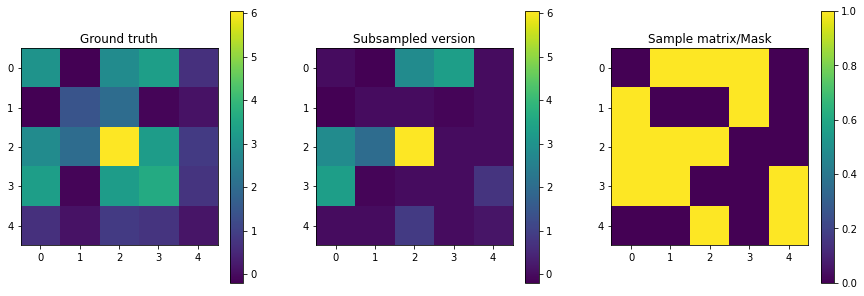

In [10]:
d = 5 # Matrix size is d*d
r = 2 # Intrisic rank
nb_s = 13 # Number of observed entries

# Fix random seed for reproducibility
np.random.seed(1)

M,S,M_sampled,U = datamatrix(d,r,nb_s)


# Plot the results
plt.figure(figsize=(15,5))
plt.get_cmap('twilight')
plt.subplot(131)
plt.title('Ground truth')
plt.imshow(M)
plt.colorbar()
plt.subplot(132)
plt.title('Subsampled version')
plt.imshow(M_sampled)
plt.colorbar()
plt.subplot(133)
plt.title('Sample matrix/Mask')
plt.imshow(S)
plt.colorbar()

## <span style="color:rgb(234,81,96)"> 3.2 Nonconvex formulation and derivatives</span>

We now focus on a nonconvex formulation of this problem. The classical, convex optimization approach consists in solving
$$
    \mathrm{minimize}_{\mathbf{W} \in \mathbb{R}^{d \times d}} \frac{1}{2} \sum_{(i,j) \in \mathcal{S}} \left( \mathbf{W}_{ij}-\mathbf{M}_{ij}\right)^2
$$
where $\mathcal{S} \subset \{1,\dots,d\}^2$ represents the set of entries of the data matrix $\mathbf{M}$ that are observed. This problem is convex, but requires the manipulation of a $d \times d$ matrix. In addition, the solution need not be low rank: in fact, to guarantee that the solution will possess the same properties add the constraint $\mathrm{rank}(\mathbf{W})=r$ in order for the problem to guarantee a low-rank approximation, plus a constraint of the form $\mathbf{W} \succeq \mathbf{0}$ to guarantee that $\mathbf{W}$ has (like $\mathbf{M}$) only nonnegative eigenvalues.

Overall, the problem we should look at is
$$
   \mathrm{minimize}_{\mathbf{W} \in \mathbb{R}^{d \times d}} \frac{1}{2} \sum_{(i,j) \in \mathcal{S}} \left( \mathbf{W}_{ij}-\mathbf{M}_{ij}\right)^2 \quad \mathrm{subject\ to} \quad 
   \mathbf{W}=\mathbf{W}^T \succeq \mathbf{0},\ \mathrm{rank}(\mathbf{W}) \le r.
$$

Instead of this formulation, we adopt the Burer-Monteiro approach and reformulate the problem using a factored representation of the problem variable $\mathbf{W}$ that highlights its low-rank structure. This leads to the following formulation:
$$
    \mathrm{minimize}_{\mathbf{U} \in \mathbb{R}^{d \times r}} \frac{1}{2}\sum_{(i,j) \in \mathcal{S}} \left( [\mathbf{U}\mathbf{U}^T]_{ij}-\mathbf{M}_{ij}\right)^2.
$$
Compared to the original formulation, our approximation of $\mathbf{M}$ is given by $\mathbf{U}\mathbf{U}^T$, which is by construction a rank-$r$ matrix, *but we only solve the problem in $\mathbf{U} \in \mathbb{R}^{d \times r}$*. This problem is unconstrained in $\mathbf{U}$ and involves only $dr$ variables by explicitly enforcing the low-rank 
property.

We would like to apply gradient descent to the following problem
$$
    \mathrm{minimize}_{\mathbf{U} \in \mathbb{R}^{d \times r}}\ f(\mathbf{U}):=
    \frac{1}{2}\sum_{(i,j) \in \mathcal{S}} \left([\mathbf{U}\mathbf{U}^T]_{ij}-\mathbf{M}_{ij}\right)^2
$$
There are two ways to approach this problem: the first one consists in viewing this problem as one on $\mathbb{R}^{d \times r}$, and do a standard gradient descent procedure. This approach allows for reusing our generic gradient descent code from above.

The second approach preserves the matrix structure of the variables, and defines the gradient of $f$ as a matrix in $\mathbb{R}^{d \times r}$ (similarly to the vector case, in which $\nabla \phi(\mathbf{x}) \in \mathbb{R}^d$ for any function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}$ and $\mathbf{x} \in \mathbb{R}^d$). In our case, we define the gradient of $f$ with respect to any $\mathbf{U} \in \mathbb{R}^{d \times r}$ as:
$$
    \nabla f(\mathbf{U}) := (\mathbf{E}+\mathbf{E}^T)\mathbf{U} \quad \mbox{where} \quad 
    \mathbf{E}:= (\mathbf{U}\mathbf{U}^T-\mathbf{M}) \otimes \mathbf{S},
$$
with $\otimes$ denoting the Hadamard/entrywise matrix product, and $\mathbf{S} \in \mathbb{R}^{d \times d}$ is 
defined by 

$$
    \mathbf{S}_{ij} = 
    \left\{
        \begin{array}{ll}
            1 &\mbox{if $(i,j) \in \mathcal{S}$} \\
            0 &\mbox{otherwise.}
        \end{array}
    \right.
$$

The two functions in the next block use this approach to encode the function value and its derivative.

In [11]:
# Objective function for the nonconvex matrix factorization problem
def f_mat(U,M_S,S):
    '''
        Function value for the low-rank matrix factorization problem.
        The solution of this problem is a matrix U such that U*U^T agrees as best as possible with M_S on its 
        non-zero entries.
        
        Inputs:
            U: d-by-r matrix (decision variables)
            M_S: Samples from the data matrix
            S: Sampling pattern
            
        Output:
            f: Value of the low-rank matrix functional at U
    '''
    E = np.dot(U,np.transpose(U))-M_S
    E = E * S
    return 0.5*np.sum(E**2)

# Objective and gradient vector for the nonconvex matrix factorization problem
def fg_mat(U,M_S,S):
    '''
        Objective and gradient vector for the low-rank matrix factorization problem.
        The solution of this problem is a matrix U such that U*U^T agrees as best as possible with M_S on its 
        non-zero entries.   
        
        Inputs:
            U: d-by-r matrix (decision variables)
            M_S: Samples from the data matrix
            S: Sampling pattern
            
        Output:
            f: Value of the low-rank matrix functional at U
            G: Value of the gradient of this functional (defined in a matrix sense) at U
    '''
    E = np.dot(U,np.transpose(U))-M_S
    E = E * S
    f = 0.5*np.sum(E**2)
    G = np.dot(E+np.transpose(E),U)
    return f,G

The *ad hoc* version of gradient descent for the low-rank matrix completion problem is given below. Note that it computes an adaptive stepsize through a backtracking line search procedure.

In [12]:
def gd_matrix(U0,fun,fungrad,f_base,step,linesearch=False,n_iter=10000, verbose=False): 
    """
        A code for gradient descent on low-rank matrix-type problems.
        
        Inputs:
            U0: Initial (rectangular) matrix
            fun: Objective function, returns f(U) for every U
            fungrad: Returns both the objective function and its gradient
            f_base: A base value to assess convergence
            step: Initial value of the stepsize
            linesearch: Boolean indicating whether or not a line search should be performed
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            U_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length at most n_iter+1)
            ngvals: History of gradient norms (output as a Numpy array of length at most n_iter+1)
            nits: Number of iterations actually performed
            flag: Termination flag
                0: Convergence in terms of function value (decrease of f_base by 1e-4)
                1: Convergence in terms of gradient norm (below 1e-3, normalized by norm(U_output))
                2: Maximum number of iterations reached
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # gradient norm history
    ngvals = []
    
    # Initial value of current iterate   
    U = U0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective and gradient value
    obj,G = fungrad(U)
    objvals.append(obj)
    ngrad = norm(G)
    ngvals.append(ngrad)

    # Plot the initial values if asked to
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))
    
    # Stopping boolean
    if (obj<=1e-4*f_base):
        flag=0
    elif (ngrad<=1e-3*norm(U)):
        flag=1
    else:
        flag=2
        
    stopping=(flag==2)
    
    ####################
    # Main loop
    while stopping:
        
        # Select the stepsize and perform the update
        if linesearch:
            if k>0:
                step = 1.1*step
            fval = fun(U-step*G)
            ngrad2 = ngrad**2
            # Loop to increase the value of L if necessary
            while (fval-obj>-0.5*step*ngrad2):
                step = step/2
                fval = fun(U-step*G)
        
        U = U - step * G
        
        # Compute the new objective and gradient
        obj,G = fungrad(U)
        objvals.append(obj)
        ngrad = norm(G)
        ngvals.append(ngrad)
        
        # Plot relevant information if asked to
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
        
        # Stopping boolean
        if (obj<=1e-4*f_base):
            flag=0
        elif (ngrad<=1e-3*norm(U)):
            flag=1
        else:
            flag=2
        stopping = (flag==2)
    
    # End main loop
    ######################
    
    # Output
    U_output = U.copy()
    nits = k
        
    return U_output, np.array(objvals), np.array(ngvals),nits,flag

We can run this method on a small-scale example and observe that it does provide a good candidate solution.

0
Objective function: 3.294970662944837e-05
Normalized gradient norm: 0.016902753742291565


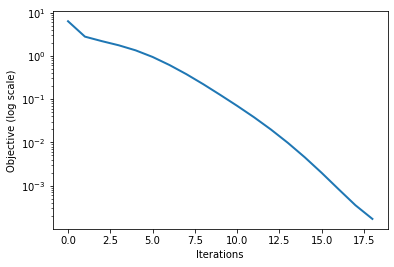

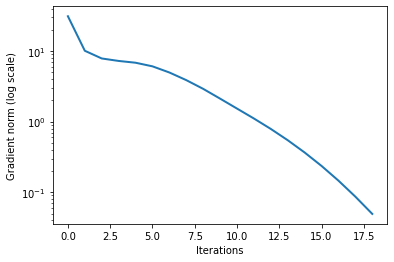

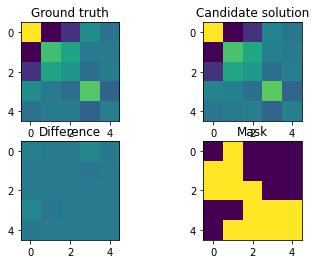

In [13]:
# Validation on a small-dimensional example

d=5
r=2
nb_s=13

M,S,M_s,U_star = datamatrix(d,r,nb_s)

fbase = 0.5*(np.sum(M_s**2))

# Run gradient descent
U0 = randn(d,r)
#U0 = U_star
U_out,obj_out,ng_out,nits,flag = gd_matrix(U0,lambda U: f_mat(U,M_s,S),lambda U: fg_mat(U,M_s,S),fbase,1.,True,10000,False)

#print(nits)
print(flag)
# Plot the results
print("Objective function:",obj_out[-1]/(norm(M_s)**2))
print("Normalized gradient norm:",ng_out[-1]/norm(U_out))
M_out = np.dot(U_out,np.transpose(U_out))

plt.figure(1)
plt.semilogy(obj_out/norm(M_s), lw=2)
plt.xlabel('Iterations')
plt.ylabel('Objective (log scale)')
plt.figure(2)
plt.semilogy(ng_out, lw=2)
plt.xlabel('Iterations')
plt.ylabel('Gradient norm (log scale)')
plt.figure(3)
plt.subplot(221)
plt.title('Ground truth')
plt.imshow(M)
plt.subplot(222)
plt.title('Candidate solution')
plt.imshow(M_out,vmin=np.amin(M_out),vmax=np.amax(M_out))
plt.subplot(223)
plt.title('Difference')
plt.imshow(M-M_out,vmin=np.amin(M_out),vmax=np.amax(M_out))
plt.subplot(224)
plt.title('Mask')
plt.imshow(S)

We now consider running gradient descent on multiple instances of this problem (i.e. use multiple data matrices).
For any instance, we consider that
- GD converges to a solution if the final function value is below $10^{-4}\|\mathbf{M}_S\|^2$;
- GD converges to a critical point but not a solution if the previous test fails but the final gradient norm is below $10^{-3}\|\mathbf{U}_K\|$, where $\mathbf{U}_K$ is the last iterate;
- GD fails to converge otherwise.

We compare the number of solved/converged/failed instances as we increase the number of observations.

10 Samples out of 81
12 Samples out of 81
14 Samples out of 81
16 Samples out of 81
18 Samples out of 81
20 Samples out of 81
22 Samples out of 81
24 Samples out of 81
26 Samples out of 81
28 Samples out of 81
30 Samples out of 81
32 Samples out of 81
34 Samples out of 81
36 Samples out of 81
38 Samples out of 81


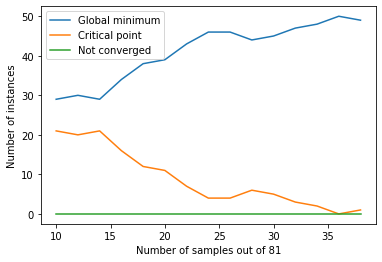

In [14]:
# Implementation - Running multiple instances

d=9
r=1
vals_s = range(10,40,2)
len_s = len(vals_s)
counter = np.zeros((len_s,3))
#
for n_it in range(0,len_s):
    nb_s = vals_s[n_it]
    print(str(nb_s) + ' Samples out of '+str(d**2)),
    for i in range(0,50):
        M,S,M_s,U_star = datamatrix(d,r,nb_s)
        nMs2 = 0.5*norm(M_s)**2
        U0 = randn(d,r)
        U_out,obj_out,ng_out,_,flag = gd_matrix(U0,lambda U: f_mat(U,M_s,S),lambda U: fg_mat(U,M_s,S),nMs2,1.,True,20000,False)
        counter[n_it,flag]+=1
#
plt.xlabel('Number of samples out of '+str(d**2))
plt.ylabel('Number of instances')
plt.plot(vals_s,counter[:,0],label='Global minimum')
plt.plot(vals_s,counter[:,1],label='Critical point')
plt.plot(vals_s,counter[:,2],label='Not converged')
plt.legend()

# <span style="color:rgb(234,81,96)">Part 4 - Gradient descent and nonconvex functions</span>

In this section, our goal is to observe the following phenomenon: ***gradient descent escapes (strict) saddle points of nonconvex functions almost surely***. Recall that a strict saddle point is a point at which the Hessian matrix possesses negative eigenvalue, or negative curvature.

## <span style="color:rgb(234,81,96)">4.1 A nonconvex quadratic toy problem</span>

We consider the problem
$$
    \mbox{minimize}_{\mathbf{w} \in \mathbb{R}^d} q(\mathbf{w}):=\frac{1}{2} \mathbf{w}^T \mathbf{A} \mathbf{w}
$$
where $\mathbf{A}$ is a diagonal matrix with entries $(1,\dots,1,-\lambda)$ on the diagonal and $\lambda \in (0,1]$. 
Note that $\|\mathbf{A}\|=1$ by definition of the operator norm.



This problem is unbounded below. Taking $\mathbf{w}=t\mathbf{e}_d$ (last vector of the canonical basis in \mathbb{R}^d) for some $t \in \mathbb{R}$ gives 
$$
    q(\mathbf{w}) = -\frac{t^2}{2}\lambda \rightarrow -\infty \quad \mbox{as} \quad t \rightarrow \pm \infty.
$$
Therefore, the function does not have a minimum.

For all $\mathbf{w} \in \mathbb{R}^d$, the gradient of this quadratic function is given by
$$
    \nabla q(\mathbf{w}) = \mathbf{A} \mathbf{w}.
$$
Thus, for any $\mathbf{v},\mathbf{w} \in \mathbb{R}^d$, we have
$$
    \|\nabla q(\mathbf{w})-\nabla q(\mathbf{v})\| 
    = \|\mathbf{A}(\mathbf{w}-\mathbf{v})\| 
    \le \|\mathbf{A}\| \|\mathbf{w}-\mathbf{v}\|.
$$
As a result, the gradient mapping $\nabla q$ is $\|\mathbf{A}\|$-continuous, and using $\|\mathbf{A}\|=1$ concludes 
the argument.

Using the characterization of convexity through the Hessian, we can show that the problem is not convex. Here $\nabla^2 q(\mathbf{w})=\mathbf{A}$, 
and the eigenvalues of $\mathbf{A}$ are $1$ and $-\lambda<0$. As a result, $\mathbf{A}$ is not positive semidefinite, and the function cannot be convex: it is nonconvex.

Moreover, looking at $\mathbf{w}=\mathbf{0}$, we see that $\nabla q(\mathbf{0})= \mathbf{0}$, thus the origin is a critical point of the problem. But the origin cannot be a local minimum or a maximum, since the Hessian at this point (as at any other point) possesses both positive and negative eigenvalues. Therefore, the origin must be a saddle point.

## <span style="color:rgb(234,81,96)">3.2 Running gradient descent</span>

We will now run multiple instances of gradient descent on this problem. To this end, we define a new Python class.

In [15]:
# Python class for purely quadratic functions
class QuadPb(object):
    '''
        A class for optimization problems of the form: minimize_w 0.5*w^T A w, with A being a symmetric matrix.
        
        Attributes:
            A: Symmetric matrix
            d: Dimension of the matrix
            
        Methods:
            fun: Compute the objective value 0.5*w^T A w for any w
            grad: Compute the gradient of the objective at any w
            lipgrad: Computes the Lipschitz constant for the gradient
    '''
   

    def __init__(self, A):
        self.A = A
        self.d = A.shape[0]
    
    # Objective value
    def fun(self, w):
        return 0.5*w.dot(A.dot(w))
    
    # Full gradient computation
    def grad(self, w):
        return A.dot(w)

    # Lipschitz constant for the gradient
    def lipgrad(self):
        L = norm(self.A, ord=2) 
        return L

The implementation can be validated via the following script.

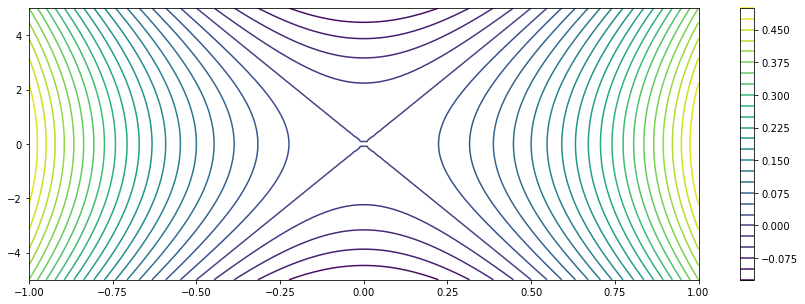

In [16]:
# Define relevant quantities
d = 2
lbda = 0.01
A = np.eye(d)
A[d-1,d-1] = -lbda

pb_ncvx = QuadPb(A)


# Plot countours of the objective function if the dimension allows it
if d==2:
    delta = 5
    w1 = np.linspace(-1,1,100)
    w2 = np.linspace(-delta,delta,100)
    fw = [[pb_ncvx.fun(np.array([u1,u2])) for u1 in w1] for u2 in w2]
    plt.figure(figsize=(15,5))
    plt.contour(w1,w2,fw,levels=30)
    plt.colorbar()

On this problem, we can check that gradient descent has escaped the saddle point at the origin. Indeed, the function value is $0$ at the origin. If the method reaches a point with negative function value, it 
will necessarily keep going downhill and reduce the function value further. We will thus use this criterion to 
certify whether or not the method has escaped the saddle point.

In the code below, we use a bunch of random points and check whether gradient descent converges to the saddle point. 

We also consider a point $\mathbf{w} \in \mbox{span}\{\mathbf{e}_1,\dots,\mathbf{e}_{d-1}\}$, i.e.
we ignore the last coordinate that corresponds to the negative eigenvalue. For such a point, gradient descent will always converge to the saddle point, because this point is optimal with respect to the first $d-1$ coordinates.

GD escaped the saddle point  100  times out of  101  random trials
GD failed on the manually chosen starting point


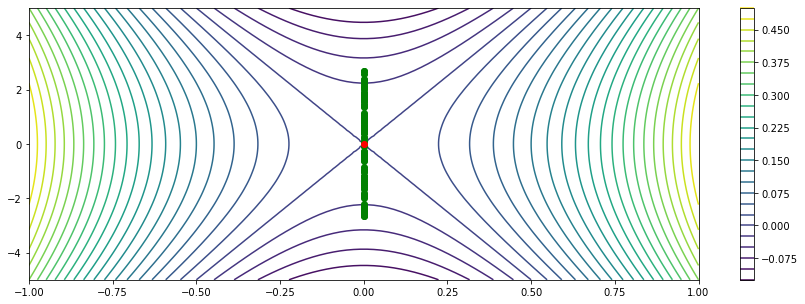

In [19]:
# Draw a bunch of random points and plot the result

ntrials = 100
w_min_lin = np.zeros(d)

# Boolean to introduce the point of Question 12-b)
failpt = True
# Define initial points and final values according to the boolean
if failpt:
    Wf = np.zeros((ntrials+1,d))
    vf = np.zeros(ntrials+1)
else:
    Wf = np.zeros((ntrials,d))
    vf = np.zeros(ntrials)

# Counting the number of "good trials" (those for which GD escaped the saddle point)
goodtrials = 0

# Run multiple instances of GD
for i in range(ntrials):
    w0 = uniform([-1,-1],[1,1],size=d)
    Wf[i,:], obj_q, nits_q = grad_desc(w0,pb_ncvx,w_min_lin,stepchoice=0,step0=1, n_iter=100,verbose=False)
    vf[i] = obj_q[-1]
    if vf[i]<0:
        goodtrials += 1
        
# Add a point of failure for GD
if failpt:
    w0 = np.ones(d)
    w0[-1] = 0 # Remove the component in the negative eigenspace
    Wf[ntrials,:], obj_q, nits_q = grad_desc(w0,pb_ncvx,w_min_lin,stepchoice=0,step0=1, n_iter=100,verbose=False)
    vf[ntrials] = obj_q[-1]
    if vf[ntrials]<0:
        goodfailpt = 1
    else:
        goodfailpt = 0
        
print('GD escaped the saddle point ',goodtrials,' times out of ', ntrials+1,' random trials')
if goodfailpt:
    print('GD succeeded on the manually chosen starting point')
else:
    print('GD failed on the manually chosen starting point')
    
# Plot the results if dimension allows it
if d==2:
    npts = vf.size
    plt.figure(figsize=(15,5))
    plt.contour(w1,w2,fw,levels=30)
    plt.colorbar()
    for i in range(npts):
        if vf[i]<0:
            plt.plot(Wf[i,0],Wf[i,1],'o',color='green')
        else:
            plt.plot(Wf[i,0],Wf[i,1],'o',color='red')

In [18]:
# Version 3.0 - C. W. Royer, October 2023